# Introducción
La empresa **Zyfra** desarrolla soluciones de eficiencia para la industria pesada y ha desarrollado un proceso tecnológico a través del cual extrae el oro del mineral. El mineral extraido se somete a un tratamiento primario para obtener la mezcla de mineral o alimentación **rougher**, que es la materia prima utilizada para la flotación. Después de la flotación, el material se somete al proceso de purificación en dos etapas que al finalizar nos proporciona el **concentrado final** y las **colas rougher** que son residuos del producto con una baja concentración de metales valiosos.

## Objetivo
Predecir la cantidad de oro extraído del mineral disponiendo de los datos de extracción y purificación.

## Tabla de contenidos

1. Introducción
2. Preparación de datos
3. Análisis de datos
4. Construcción de modelos de regresión
5. Conclusiones

# Preparando los datos

Nos proporcionan 3 datasets con finalidades específicas que son las siguientes:

- `gold_recovery_train.csv`: el cuál contiene los registros de entrenamiento.
- `gold_recovery_test.csv`: el cuál contiene los registros de prueba.
- `gold_recovery_full.csv`: el cuál contiene el total de registros (de entrenamiento y testeo).

Comenzaremos explorando `gold_recovery_train.csv` y `gold_recovery_test.csv` para poder evaluar la calidad de los registros.

In [1]:
# Importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Leyendo archivos csv
recovery_train = pd.read_csv('datasets/gold_recovery_train.csv',index_col='date')
recovery_test = pd.read_csv('datasets/gold_recovery_test.csv',index_col='date')
recovery_full = pd.read_csv('datasets/gold_recovery_full.csv',index_col='date')

In [3]:
# Explorando "recovery_train"
recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

In [4]:
# Explorando "recovery_train"
recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

Analizando ambos set de datos, nos damos cuenta de entrada de lo siguiente:

- El tamaño es completamente diferente entre `recovery_train` y `recovery_test` siendo de `(16860,87)` y `(5856,53)` respectivamente.


- En las columnas de `recovery_train` podemos observar el proceso tecnológico completo que consta de las siguientes etapas:


    - Mezcla de mineral de oro
    - Proceso de flotación
    - Concentrado Rougher
    - Primera etapa del proceso de limpieza
    - Segunda etapa del proceso de limpieza
    - Concentrado final
    - Colas Rougher
    
    
- También podemos observar que los registros no solo contienen datos referentes al `Oro` como mineral, también consideran `Plata (Ag)`, `Plomo (Pb)` y `Sol (coloide de partículas sólidas muy pequeñas en un medio)`.


- Podemos observar que hay registros faltantes en varias columnas tanto de `recovery_train` como de `recovery_test`.


- Todos los tipos de datos a excepción de `date` que es del tipo `str` son tipo `float`.


De manera general y para fines de explicación, haremos una comparativa entre los datos que se encuentran en `recovery_train` y `recovery_test` para entender cuales podrían ser sus diferencias y similitudes

Para el caso de `recovery_train`:

- `rougher.input.feed_au`: Es la **materia prima** que ingresa al proceso tecnológico.
- `rougher.output.tail_au`: Son los residuos del producto despues del proceso de **flotación**.
- `rougher.output.concentrate_au`: Concentrado de materia prima despues del proceso de **flotación** que entra al proceso uno de **limpieza**.
- `primary_cleaner.output.tail_au`: Son los residuos del producto despues del proceso uno de **limpieza**.
- `primary_cleaner.output.concentrate_au`: Concentrado de materia prima despues del proceso de uno de **limpieza** que entra al proceso dos de **limpieza**.
- `secondary_cleaner.output.tail_au`: Son los residuos del producto despues del proceso dos de **limpieza**.
- `final.output.tail_au`: Son los residuos del producto final despues del proceso dos de **limpieza**.
- `final.output.concentrate_au`: Concentrado de materia prima al finalizar del proceso tecnológico de extracción.

Ademas de el detalle del estado en el que se encuentra cada una de las etapas del proceso (`flotación`, `primer etapa de limpieza` y `segunda etapa de limpieza`).

Para el caso de `recovery_test`:

- `rougher.input.feed_au`: Es la **materia prima** que ingresa al proceso tecnológico.

Como podemos observar a detalle en esta sección, el set de datos que usaremos de `testeo` del modelo, contiene unicamente como columna en común **la cantidad de matería prima inicial**, por otro lado contiene el detalle del estado en el que se encuentra cada una de las etapas del proceso (`flotación`, `primer etapa de limpieza` y `segunda etapa de limpieza`).

De manera inmediata también nos percatamos que practicamente en todas las columnas nos encontramos con valores ausentes, lo que nos podría llevar a un problema de cálculos posteriores. Por tal motivo, debemos encontrar dichos valores faltantes dentro de `recovery_train`.

In [5]:
# Encontrando valores ausentes
pd.options.display.max_rows = 100
recovery_train.isna().sum().sort_values(ascending=False)

rougher.output.recovery                               2573
rougher.output.tail_ag                                2250
rougher.output.tail_sol                               2249
rougher.output.tail_au                                2249
secondary_cleaner.output.tail_sol                     1986
rougher.input.floatbank11_xanthate                    1904
final.output.recovery                                 1521
primary_cleaner.input.sulfate                         1307
primary_cleaner.input.depressant                      1262
rougher.calculation.au_pb_ratio                       1242
rougher.input.floatbank10_sulfate                     1044
primary_cleaner.input.xanthate                         985
primary_cleaner.output.concentrate_sol                 636
rougher.input.floatbank11_sulfate                      623
rougher.state.floatbank10_e_air                        603
rougher.input.feed_rate                                513
rougher.input.feed_size                                4

Como podemos observar es una gran cantidad de registros nulos en total los que se tienen por lo que de manera inmediata nos percatamos que no podemos descartar simplemente las filas con registros nulos, por otro lado sabemos que los datos a través del tiempo son muy similar y por tal motivo, procederemos a encontrar dichos datos haciendo uso de la función `fillna` haciendo uso del hiper parámetro `method = ffill`.

In [6]:
# Trabajando los valores ausentes para "recovery_train"
recovery_train.fillna(method='ffill',inplace=True)
pd.options.display.max_rows = 100
recovery_train.isna().sum().sort_values(ascending=False)

final.output.concentrate_ag                           0
rougher.state.floatbank10_b_air                       0
rougher.state.floatbank10_f_air                       0
rougher.state.floatbank10_e_level                     0
rougher.state.floatbank10_e_air                       0
rougher.state.floatbank10_d_level                     0
rougher.state.floatbank10_d_air                       0
rougher.state.floatbank10_c_level                     0
rougher.state.floatbank10_c_air                       0
rougher.state.floatbank10_b_level                     0
rougher.state.floatbank10_a_level                     0
secondary_cleaner.output.tail_ag                      0
rougher.state.floatbank10_a_air                       0
rougher.output.tail_au                                0
rougher.output.tail_sol                               0
rougher.output.tail_pb                                0
rougher.output.tail_ag                                0
rougher.output.recovery                         

De la misma manera trabajaremos con `recovery_test`.

In [7]:
# Trabajando los valores ausentes para "recovery_test"
recovery_test.fillna(method='ffill',inplace=True)
pd.options.display.max_rows = 100
recovery_test.isna().sum().sort_values(ascending=False)

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
secondary_cleaner.state.floatbank2_a_air      0
secondary_cleaner.state.floatbank2_a_level    0
secondary_cleaner.state.floatbank2_b_air      0
secondary_cleaner.state.floatbank2_b_level    0
secondary_cleaner.state.floatbank3_a_air      0
secondary_cleaner.state.floatbank3_a_level    0
secondary_cleaner.state.floatbank3_b_air      0
secondary_cleaner.state.floatbank3_b_level    0
secondary_cleaner.state.floatbank4_a_air      0
secondary_cleaner.state.floatbank4_a_level    0
secondary_cleaner.state.floatbank4_b_air      0
secondary_cleaner.state.floatbank4_b_level    0
secondary_cleaner.state.floatbank5_a_air

## Cálculo de recuperación

Continuaremos realizando el cálculo de la recuperación y validar si es correcto el cuál será comparado con la columna `rougher.output.recovery`. Para poder hacer esta operación, debemos conocer su fórmula y cuáles son los parámetros que esta recibe.

$$
recuperación = \frac{C * (F - T)}{F * (C - T)} * 100 %
$$

Donde:

- `C`: proporción de oro en el concentrado justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final).
- `F`: la proporción de oro en la alimentación antes de la flotación (para saber la recuperación del concentrado rougher)/en el concentrado justo después de la flotación (para saber la recuperación del concentrado final).
- `T`: la proporción de oro en las colas rougher justo después de la flotación (para saber la recuperación del concentrado rougher)/después de la purificación (para saber la recuperación del concentrado final).

Para automatizar este proceso, primero eliminaremos aquellas filas incongruentes en un inicio, es decir:

- Filas en las que `rougher.input.feed_{metal}` sea igual a `0`.
- Filas en las que `final.output.concentrate_{metal}` sea igual a `0`.
- Filas en las que `rougher.output.concentrate_{metal}` sea igual a `0`.

Esto es porque es más que evidente que si alimentamos el proceso con una cantidad de `0` de materia prima, al terminar el mismo, no tendremos resultado alguno ademas que al momento de hacer la división, las divisiones entre cero causan una indeterminación.

Comenzaremos dando un vistazo a la columna `rougher.output.recovery`.

In [8]:
# Eliminando filas con "rougher.input.feed_{metal} = 0"
for metal in ['au','ag','pb','sol']:
    recovery_train = recovery_train[recovery_train[f'rougher.input.feed_{metal}'] != 0]
    recovery_test = recovery_test[recovery_test[f'rougher.input.feed_{metal}'] != 0]
    recovery_train = recovery_train[recovery_train[f'final.output.concentrate_{metal}'] != 0]
    recovery_train = recovery_train[recovery_train[f'rougher.output.concentrate_{metal}'] != 0]

recovery_train.shape, recovery_test.shape

((15061, 86), (5465, 52))

In [9]:
# Visualizando "rougher.output.recovery`"
recovery_target = recovery_train['rougher.output.recovery'].head()
recovery_target

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
Name: rougher.output.recovery, dtype: float64

Para fines de validación podriamos realizar la operación de `recuperación` con estos primeros 5 registros para validar los resultados y verificar que esta ha sido aplicada de forma correcta.

Encontraremos primero a `C`, despues `F` y `T` para terminar aplicando la formula.

In [10]:
# Encontrando el valor de "C"
C = recovery_train['rougher.output.concentrate_au'].head()/recovery_train['final.output.concentrate_au'].head()


In [11]:
# Encontrando el valor de "F"
F = recovery_train['rougher.input.feed_au'].head()/recovery_train['rougher.output.concentrate_au'].head()


In [12]:
# Encontrando el valor de "T"
T = recovery_train['rougher.output.tail_au'].head()/recovery_train['final.output.concentrate_au'].head()


In [13]:
# Aplicando la formula de "recuperación" y comparando las muestras
recovery_calculate = ((C * (F - T))/(F * (C - T))) * 100

In [14]:
# Visualizando resultados
pd.DataFrame(data={'recovery_target':recovery_target,
                   'recovery_calculate':recovery_calculate})

,recovery_target,recovery_calculate
date,,
2016-01-15 00:00:00,87.107763,97.287558
2016-01-15 01:00:00,86.843261,97.153379
2016-01-15 02:00:00,86.842308,97.275038
2016-01-15 03:00:00,87.226430,97.459205
2016-01-15 04:00:00,86.688794,97.083794


De manera inmediata podemos visualizar un cálculo que es aproximadamente `10 unidades` por encima de los resultados presentados en `recovery_train`. Crearemos una función que realice el cálculo de `recuperación` y la aplicaremos todo el conjunto.

In [15]:
# Creando la función "recovery"
def recovery(data,metal):
    
    C = data[f'rougher.output.concentrate_{metal}']
    F = data[f'rougher.input.feed_{metal}']
    T = data[f'rougher.output.tail_{metal}']
        
    return ((C*(F-T))/(F*(C-T)))*100

recovery_calculate = pd.DataFrame(columns=['au','ag','pb','sol'])
for metal in recovery_calculate.columns:
    recovery_calculate[metal] = recovery_train.apply(func=recovery,args=(metal,),axis=1)

In [16]:
# Encontrando la recuperación
recovery_target = recovery_train['rougher.output.recovery']
eam = pd.DataFrame({'calculation':recovery_calculate['au'],'target':recovery_target})
eam

,calculation,target
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308
2016-01-15 03:00:00,87.226430,87.226430
2016-01-15 04:00:00,86.688794,86.688794
...,...,...
2018-08-18 06:59:59,89.574376,89.574376
2018-08-18 07:59:59,87.724007,87.724007
2018-08-18 08:59:59,88.890579,88.890579


Una vez que hemos hecho el cálculo de la recuperación, procederemos a calcular el `error absoluto medio` con la intención de poder obtener una medida de diferencia entre `calculation` y `target`.

## Obteniendo el "error aboluto medio"

In [17]:
# Calculando el "error absoluto medio" de "eam"
mean_absolute_error(recovery_target,recovery_calculate['au'])

61.36676974305466

Como podemos observar, tenemos un `error absoluto medio` relativamente elevado, esto es de esperarse pues es un resultado que no necesariamente significa que sea malo pues lo que podemos asumir es que esa diferencia de hasta `61.36 unidades` está dada porque en la realidad se observa una cantidad menor en la recuperación puesto que hay matería que se va perdidiendo por otros factores a considerear y no solamente los que se toman en cuenta para el cálculo.

# Analisis de datos

## Cambio de concentración de metales en función de la etapa de purificación

Con la intención de poder observar como es que afecta el procedimiento de `purificación (Primera etapa de limpieza y segunda etapa de limpieza)` vamos a analizar los resultados de la materia entrante a esta etapa y cuales son los resultados que se tienen al salir de la misma. Esto será analizado sobre `recovery_train_result`.

Las columnas de interes son:

- `rougher.output.concentrate_(metal)`
- `primary_cleaner.output.tail_(metal)`
- `primary_cleaner.output.concentrate_(metal)`
- `secondary_cleaner.output.tail_(metal)`
- `final.output.concentrate_(metal)`

In [18]:
# Recuperando columnas de interes
metal_concentrate = {"gold": pd.DataFrame(data={'rougher.input.feed_au':recovery_train['rougher.input.feed_au'],
                                                'rougher.output.concentrate_au':recovery_train['rougher.output.concentrate_au'],
                                                'primary_cleaner.output.concentrate_au':recovery_train['primary_cleaner.output.concentrate_au'],
                                                'final.output.concentrate_au':recovery_train['final.output.concentrate_au']}),
                     "silver": pd.DataFrame(data={'rougher.input.feed_ag':recovery_train['rougher.input.feed_ag'],
                                                  'rougher.output.concentrate_ag':recovery_train['rougher.output.concentrate_ag'],
                                                  'primary_cleaner.output.concentrate_ag':recovery_train['primary_cleaner.output.concentrate_ag'],
                                                  'final.output.concentrate_ag':recovery_train['final.output.concentrate_ag']}),
                     "lead": pd.DataFrame(data={'rougher.input.feed_pb':recovery_train['rougher.input.feed_pb'],
                                                'rougher.output.concentrate_pb':recovery_train['rougher.output.concentrate_pb'],
                                                'primary_cleaner.output.concentrate_pb':recovery_train['primary_cleaner.output.concentrate_pb'],
                                                'final.output.concentrate_pb':recovery_train['final.output.concentrate_pb']})}


In [19]:
# Creando la función de distribución
def metal_concentration(data):
    metals = list(data.keys())
    for metal in metals:
        data[metal].plot.hist(title=f'{metal} distribution',bins=100,alpha=0.5,figsize=(20,6))
        plt.show()

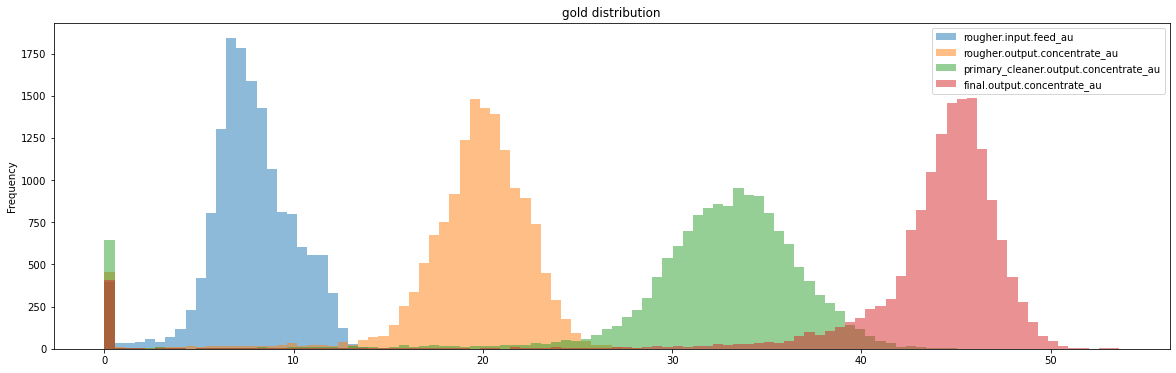

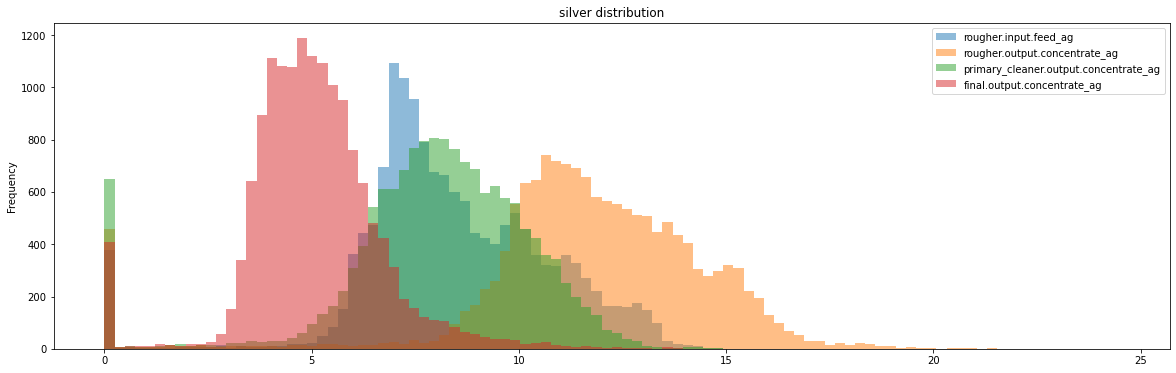

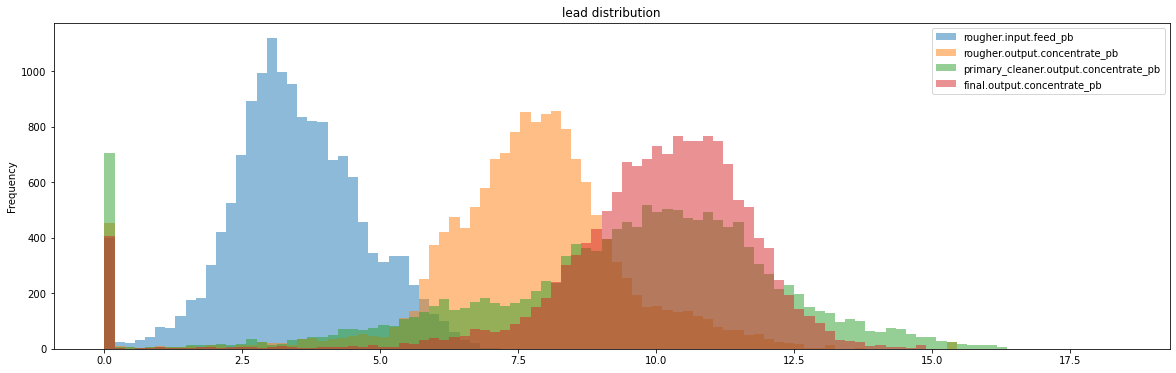

In [20]:
# Ejecutando la función "metal_concentration"
metal_concentration(metal_concentrate)

De acuerdo con las distribuciones podemos observar que el proceso de purificación de manera general ayuda aun más a que la materia introducida se obtenga sin tener tantas perdidas de los metales y que estos salgan lo más limpios posibles, en específico para:

- `Oro`: podemos observar que al finalizar la etapa de `purificación` la concentración de este aumenta considerablemente, lo que nos lleva a concluir que el proceso es eficiente para este metal.
- `Plata`: caso contrario al metal anteriormente abordado, podemos ver una disminución considerable en la concentración del metal al finalizar el proceso de `purificación` lo que nos indica que el proceso no es adecuado para la extracción de este metal.
- `Plomo`: para el caso de este metal podemos observar que la concentración de este metal aumenta de forma mínima por lo que podrimos considerar que este proceso no es el más adecuado para la extracción de este metal.

En conclusión de forma general, podemos observar que este proceso aumenta considerablemente la concentración de `Oro` en específico al finalizar y podemos considerarlo en proceso optimo para su extracción.

Continuaremos con la validación de ambos sets comparando las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Esto debe realizarse debido a que estas no deben ser muy diferentes pues hablaría que el set de `testeo` no fue sacado del todo del set `total`.

## Compara las distribuciones del tamaño de las partículas de la alimentación

In [21]:
# Recuperando columnas de interes
feed = {'gold': pd.DataFrame(data={'train':recovery_train['rougher.input.feed_au'],
                                   'test':recovery_test['rougher.input.feed_au']}),
        'silver': pd.DataFrame(data={'train':recovery_train['rougher.input.feed_ag'],
                                     'test':recovery_test['rougher.input.feed_ag']}),
        'lead': pd.DataFrame(data={'train':recovery_train['rougher.input.feed_pb'],
                                   'test':recovery_test['rougher.input.feed_pb']})}

Haciendo uso nuevamente de `metal_concentration`, podremos observar la distribución del tamaño de las partículas de alimentación en cada conjunto de datos.

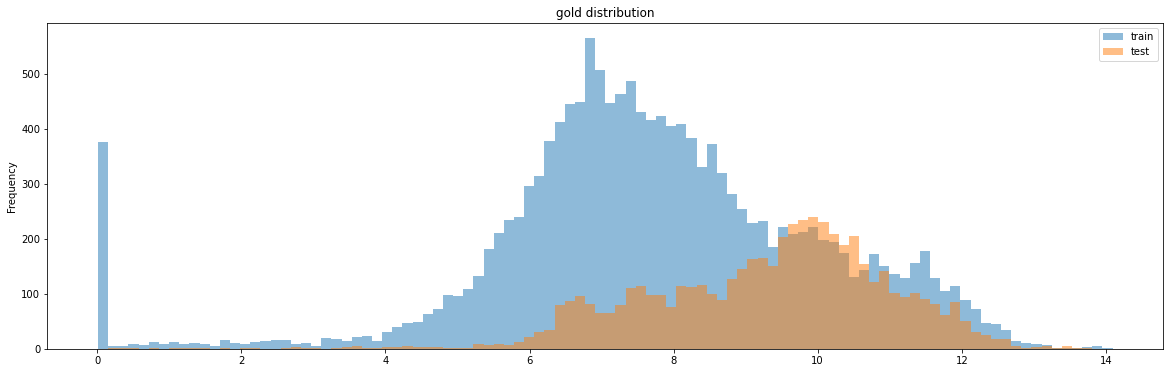

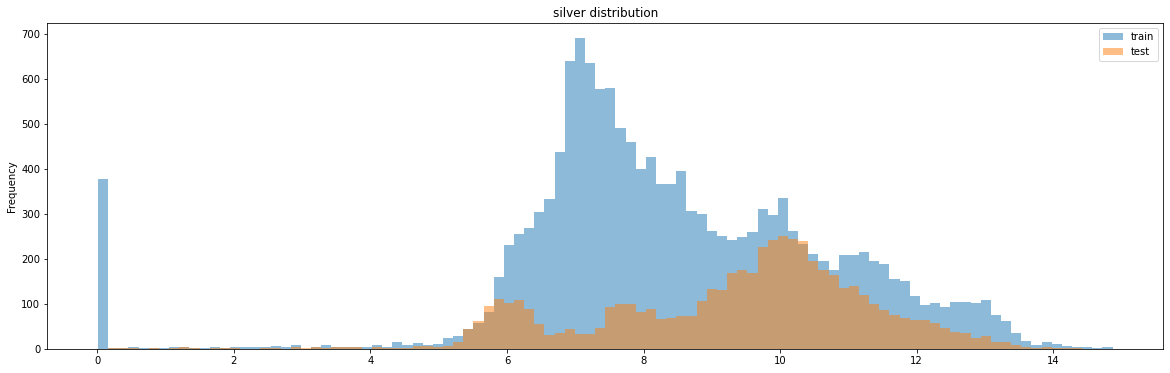

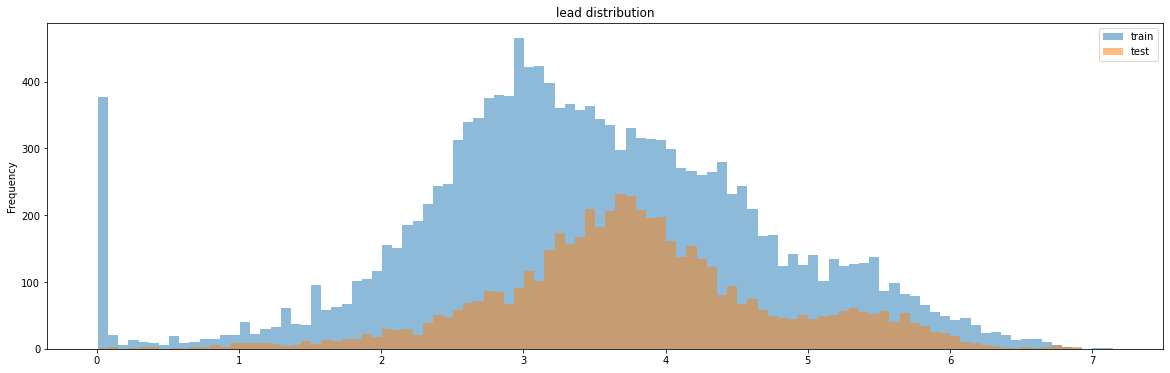

In [22]:
# Graficando la distribución
metal_concentration(feed)

Como podemos apreciar en la distribución, si bien es notoria una diferencia entre la frecuencia, esto es normal debido a la cantidad de datos que maneja el `set de entrenamiento` en comparación del de `testeo`, por otro lado, podemos observar que la distribución corresponde en cuanto al tamaño de las particulas de alimentación contenidas en cada conjunto.

Por último buscaremos anomalías en las concentraciones de las sustancias en las diferentes etapas del proceso, más especificamente en:

- `materia prima`
- `concentrado rougher`
- `concentrado final`

In [23]:
# Recuperando columnas de interes
anomalies = {"gold": pd.DataFrame(data={'rougher.input.feed_au':recovery_train['rougher.input.feed_au'],
                                        'rougher.output.concentrate_au':recovery_train['rougher.output.concentrate_au'],
                                        'final.output.concentrate_au':recovery_train['final.output.concentrate_au']}),
             "silver": pd.DataFrame(data={'rougher.input.feed_ag':recovery_train['rougher.input.feed_ag'],
                                          'rougher.output.concentrate_ag':recovery_train['rougher.output.concentrate_ag'],
                                          'final.output.concentrate_ag':recovery_train['final.output.concentrate_ag']}),
             "lead": pd.DataFrame(data={'rougher.input.feed_pb':recovery_train['rougher.input.feed_pb'],
                                        'rougher.output.concentrate_pb':recovery_train['rougher.output.concentrate_pb'],
                                        'final.output.concentrate_pb':recovery_train['final.output.concentrate_pb']})}


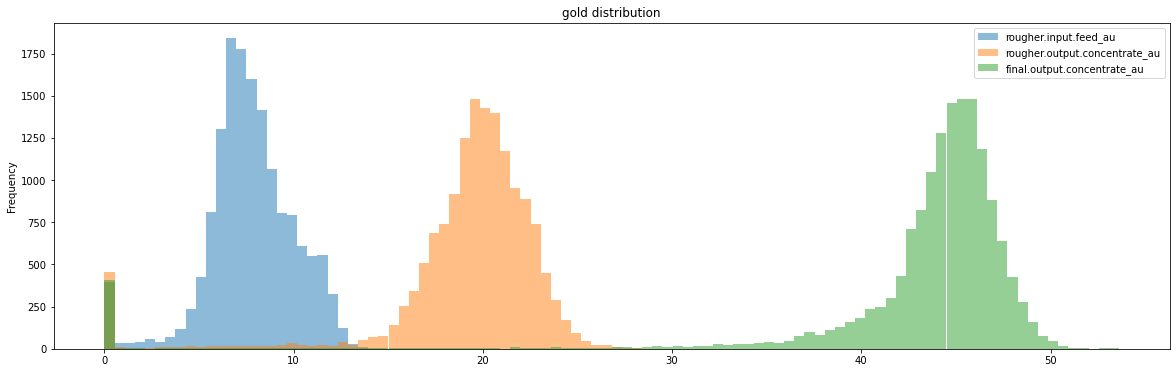

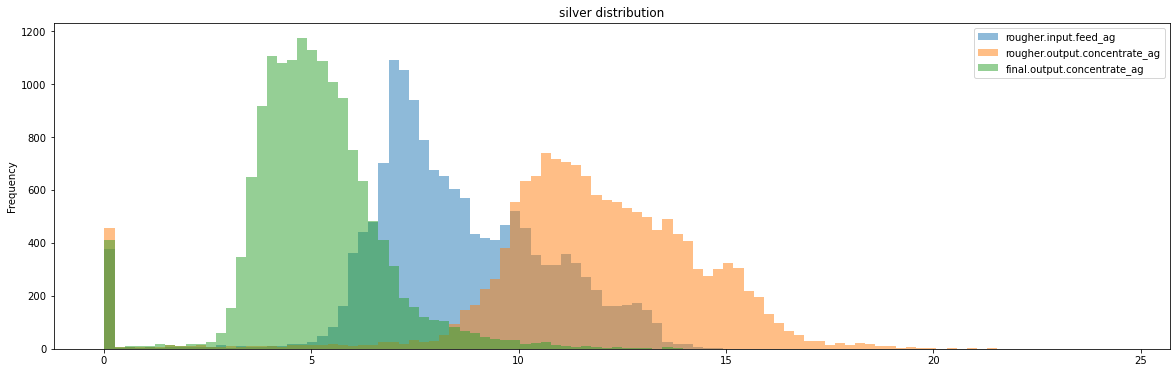

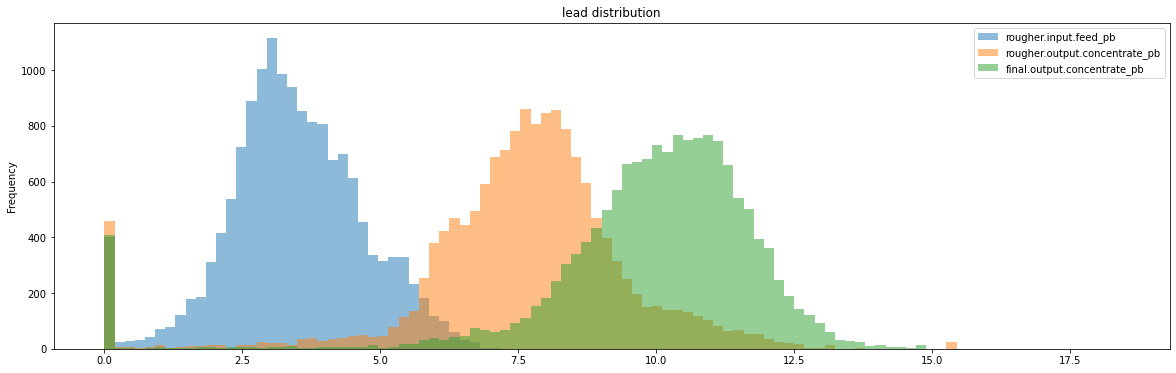

In [24]:
# Graficando las distribuciones
metal_concentration(anomalies)

Como podemos ver en la distribución de los 3 metales hay valores que se encuentra en `0` en las 3 etapas del proceso analizadas lo que nos lleva a pensar que son registros que no son funcionales para nuestro modelo puesto que incluso si como matería prima, introducimos un concentrado en `0`, es de esperarse que al finalizar el proceso tengamos un resultado de `0` igualmente, por otro lado podemos observar que también el concentrado de materia prima podría ser mínimo lo que provoca que a lo largo del proceso se pierda por completo el metal y por consiguiente nos lleva a pensar en la condicional que cierta cantidad mínima de concentrado debe ser ingresada al proceso para que al finalizar, obtengamos un resultado adoc.

Es por lo anterior que todos aquellos registros que tengan un valor de cero en cualquiera de estas columnas para los distintos metales, será eliminado de ambos datasets con fines de evitar sesgos en los datos.

In [25]:
# Eliminando anomalias del set de entrenamiento
res_train = recovery_train
res_train = res_train[(res_train['rougher.input.feed_au'] != 0) & (res_train['rougher.output.concentrate_au'] != 0) & (res_train['final.output.concentrate_au'] != 0) &
                      (res_train['rougher.input.feed_ag'] != 0) & (res_train['rougher.output.concentrate_ag'] != 0) & (res_train['final.output.concentrate_ag'] != 0) &
                      (res_train['rougher.input.feed_pb'] != 0) & (res_train['rougher.output.concentrate_pb'] != 0) & (res_train['final.output.concentrate_pb'] != 0)]
res_train

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,105.666118,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452


In [26]:
# Eliminando anomalias del set de testeo
res_test = recovery_test
res_test = res_test[(res_test['rougher.input.feed_au'] != 0) &
                    (res_test['rougher.input.feed_ag'] != 0) & 
                    (res_test['rougher.input.feed_pb'] != 0)]
res_test

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882


Una vez teniendo los registros en óptimas condiciones de ambos datasets, procederemos con la creación del modelo de regresión basado en que buscamos valores continuos a lo largo de esta información como resultado. 

Tomando en cuenta que buscamos dos valores que son `rougher.output.recovery` y `final.output.recovery` haremos uso de dos modelos los cuales evaluaremos haciendo validación cruzada, ademas también, de igual forma aplicaremos la siguiente formula como métrica de evaluación:

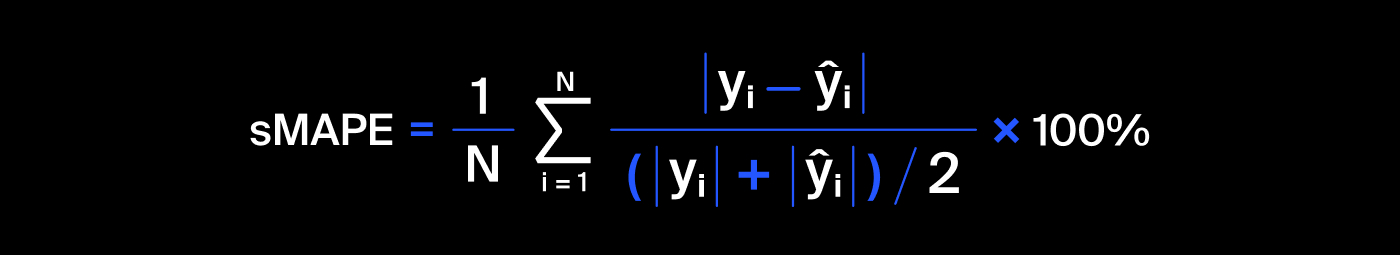

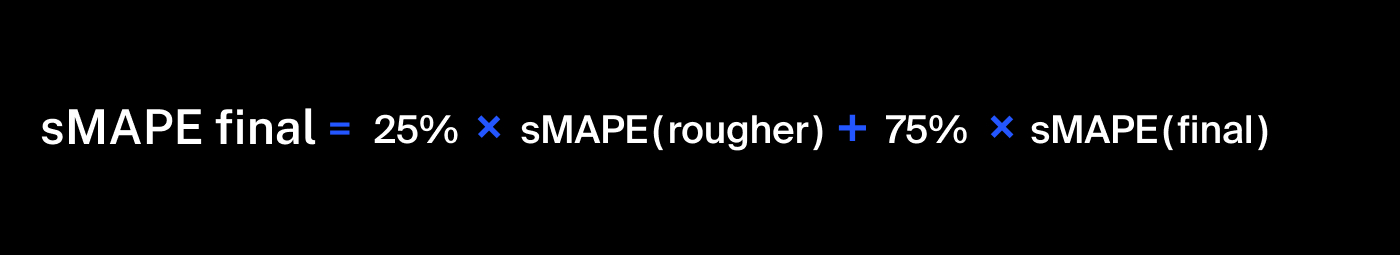

# Construyendo el modelo

Comenzaremos creando la función para poder calcular **sMAPE**.

In [27]:
# Construyendo la funcion smape
def smape(y_test,y_pred):
    num = (y_test - y_pred).abs()
    den = (y_test.abs()-y_pred.abs())/2
    return (num / den).mean() * 100

def smape_final(y_test, y_pred):
    rougher = smape(y_test['output_recovery'], y_pred['output_recovery'])
    recovery = smape(y_test['final_recovery'], y_pred['final_recovery'])
    return 0.25*rougher + 0.75*recovery
    

Antes de pasar a los modelos de `machine learning` debemos trabajar lo último del set de entrenamiento, esto es debido a que como vimos al principio, el set de `testeo` no cuenta con la misma cantidad de características que el set de `entrenamiento` por lo que debemos ajustar dichas características para poder entrenar adecuadamente. Por otro lado, tenemos como objetivo dos columnas que son:

- `rougher.output.recovery` 
- `final.output.recovery`

Que ambas deben ser predichas por el mismo modelo lo cuál implica que hagamos uso de un método llamado `KFold`, el cuál nos permite trabajar con dos o más objetivos.

Primero trabajaremos con las variables de entrenamiento.

In [28]:
# Variables de entrenamiento
X_train = res_train[res_test.columns].reset_index(drop=True)
y_train = res_train[['rougher.output.recovery','final.output.recovery']].reset_index(drop=True)
X_train.shape, y_train.shape

((15061, 52), (15061, 2))

Ahora trabajaremos con las variables de testeo.

In [29]:
X_test = res_test.reset_index(drop=True)
y_test = recovery_full.loc[res_test.index, ['rougher.output.recovery','final.output.recovery']].reset_index(drop=True)
y_test.columns = ['output_recovery','final_recovery']
X_test.shape, y_test.shape

((5465, 52), (5465, 2))

Una vez tenemos los datos de entrenamiento y testeo listos, podemos probar con los modelos de machine learning de regresión para poder validar y elegir el de mejor desempeño.

Los modelos a trabajar serán:

- Regresión lineal
- Árboles de decisión
- Bosques aleatorios

Primero crearemos la funcion `models` la cuál se encargará de la validación cruzada recibiendo el modelo que se este trabajando y retornando el `score` de desempeño que este tiene.

## Función de validación cruzada

In [30]:
def models(model):
    kf = KFold(n_splits=5)
    
    score = []
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train),start=1):
        X = X_train.loc[train_idx].reset_index(drop=True)
        y = y_train.loc[train_idx].reset_index(drop=True)
        X_valid = X_train.loc[valid_idx].reset_index(drop=True)
        y_valid = y_train.loc[valid_idx].reset_index(drop=True)
        y_valid.columns = ['output_recovery','final_recovery']

        model.fit(X,y)
        y_pred = model.predict(X_valid)
        y_pred = pd.DataFrame(y_pred)
        y_pred.columns = ['output_recovery','final_recovery']

        result = score.append(smape_final(y_valid,y_pred))

    print(f'El score para el modelo es de:',np.mean(score))

Una vez teniendo `models`, comenzaremos con los modelos de regresión partiendo con el de `regresión lineal`.

## Modelo de "regresión lineal"

In [31]:
# Preparando modelo de regresión
model_lr = LinearRegression(n_jobs=-1)
models(model_lr)

El score para el modelo es de: 15.171882444775608


Como podemos observar, el `score` que arroja el modelo de `regresión lineal`, no se ajusta a las características de la información y por tal motivo, no podemos hacer uso del mismo como modelo de predicción, por tal motivo, implemetaremos el modelo de `árboles de decisión`.

## Modelo de "árboles de decisión"

Primero buscaremos cuales son los hiperparámetros que nos arrojan el modelo de `árboles de decisión` mejor ajustado para postriormente construir el adecuado y hacer la validación cruzada correspondiente

In [39]:
# Preparando modelo de regresión
model_dtr = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range(2, 4), 
              'min_samples_split': range(2, 10,2), 
              'min_samples_leaf': range(2, 10,2),
              'criterion': ['squared_error', 'friedman_mse','poisson']}
grid = GridSearchCV(model_dtr, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score:  -0.05885269113604251
Best estimator:  DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, min_samples_leaf=2,
                      random_state=12345)


In [40]:
# Creando modelo de regresión
model_dtr = DecisionTreeRegressor(random_state=12345,
                                  max_depth=3,
                                  min_samples_split=2,
                                  min_samples_leaf=2,
                                  criterion='friedman_mse')
models(model_dtr)

El score para el modelo es de: 25.720527558975295


Aunque observamos un buen desempeño, no obtenemos un resultado del todo satisfactorio, por lo que procederemos a ejecutar el siguiente modelo de regresión que es `Bosques aleatorios`.

## Modelo de "bosques aleatorios"

In [43]:
# Preparando modelo de regresión
model_rfr = RandomForestRegressor(random_state=12345)
parameters = {'max_depth': range(2,4),
              'min_samples_split': range(2,10,2),
              'min_samples_leaf': range(2,10,2),
              'criterion': ['squared_error','friedman_mse','poisson']}
grid = GridSearchCV(model_rfr, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best score:  0.007601532954330792
Best estimator:  RandomForestRegressor(max_depth=2, min_samples_leaf=6, random_state=12345)


In [45]:
model_rfr = RandomForestRegressor(random_state=12345,
                                  n_estimators=100,
                                  max_depth=2,
                                  min_samples_split=2,
                                  min_samples_leaf=6,
                                  criterion='squared_error')
models(model_rfr)

El score para el modelo es de: 15.110561184843547


De acuerdo con los resultados, podemos observar que el modelo con mejor desempeño es `Bosques aleatorios` esto es debido a la interpretación de la métrica de evaluación que estamos utilizando que es `sMAPE` que a grandes razgos expresa que el modelo tiene un porcentaje bajo de error en sus predicciones y es capaz de hacer predicciones precisas. Lo que buscamos en este punto es el `score` más bajo y si bien `Regresión lineal` fue otro modelo con buen rendimiento, por muy poco la precisión de predicción de `Bosques aleatorios` es mejor puesto que solo tiene un margen de error de a lo más `15%`.

Procederemos con hacer uso del modelo seleccionado por la `validación cruzada` para probar el `res_test` y verificaremos su desempeño.

## Probando "bosques aleatorios" con el set de testeo

In [46]:
# Aplicando el modelo al set de testeo
y_pred = model_rfr.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['output_recovery','final_recovery']
smape_final(y_test,y_pred)

78.59274091203926

# Conclusiones

El tener una métrica de evaluación como `sMAPE` nos invita a investigar cuál es su interpretación puesto que a diferencia del método `score` que hemos venido manejando en los diferentes modelos de `machine learning` esta métrica nos arroja la probabilidad de cometer errores al momento de hacer predicciones lo que nos llevo a evaluar con 3 diferentes modelos de regresión de los cuales el de mejor desempeño fue `bosques aleatorios` por su alto desempeño de predicción con baja tendencia a errores. Por otro lado se tuvo la necesidad de conocer un poco sobre series de tiempo (tema para sprints posteriores) debido a la dificultad implementada en los datasets proporcionados. Entender el proceso de proceso técnologico fue punto clave para poder realizar los distintos cálculos y validaciones.

Nos encontramos también que aunque el proceso es eficiente para algunos metales, no lo es para todos puesto que algunos datos generan cierta incongruencia entre la cantidad de materia que entra en las diferentes etapas y la que sale, así también, se tuvierón algunas filas que desde el inicio agregaban una cantidad de 0 de materia prima lo cuál también podría haber provocado sesgos en el aprendizaje de los modelos si hubieran sido consideradas como datos de alimentación para los mismos.

El definitiva este proyecto puso a prueba a modo de enfrentarse a un problema más real pues requirio investigación, detenimiento en los detalles y muchos puntos de vista a considerar a lo largo del mismo.